In [1]:
import os
import numpy as np
import pandas as pd
from numpy.linalg import svd
import matplotlib.pyplot as plt
from IPython.display import clear_output

###
import utils.dhs_config as dhs_config
import utils.dhs_utils as dhs
from utils.ot import *

## Data

In [2]:
# Main folder with respect from the scripts
MAIN = "../"

# Data folder
DATA = os.path.join(MAIN, "data")

# Raw data folder (where .sav files are)
RAW_DATA = os.path.join(DATA, "raw")

# Transformed data folder
TRS_DATA = os.path.join(DATA, "transformed")

column_variables, column_others = dhs_config.get_columns()

if not(os.path.exists(os.path.join(TRS_DATA, 'df_all.csv'))):
    df_all, couple_all = dhs.get_all_data(RAW_DATA,
                                          column_variables + column_others)
    
    # In year 1994 and 1996 there is some change in the psy question
    # so we skip thoses and also only take the variables of interest
    df_reduce = df_all[~df_all.year.isin([1994, 1996])][column_variables]
    couple_reduce = couple_all[~couple_all.year.isin([1994, 1996])]
    couple_clean = couple_reduce[couple_reduce.married == 1]

    # we clean the data and drop schooling as we did not have the time to clean it
    teg_dict, spaar_dict = dhs_config.get_dict()
    df_clean = df_reduce.replace(teg_dict).replace(spaar_dict).drop('scholing', axis=1)
    
    df_all.to_csv(os.path.join(TRS_DATA, 'df_all.csv'))
    couple_all.to_csv(os.path.join(TRS_DATA, 'couple_all.csv'))
    df_clean.to_csv(os.path.join(TRS_DATA, 'df_clean.csv'))
    couple_clean.to_csv(os.path.join(TRS_DATA, 'couple_clean.csv'))

else:
    df_clean = pd.read_csv(os.path.join(TRS_DATA, 'df_clean.csv'), index_col=0)
    couple_clean = pd.read_csv(os.path.join(TRS_DATA, 'couple_clean.csv'), index_col=0)

# Estimating matching affinity matrix under low-rank constraints
 In the paper, the authors address the problem of estimating transport surplus (a.k.a. matching affinity) in high dimensional optimal transport problems. Classical optimal transport theory specifies the matching affinity and determines the optimal joint distribution. In contrast, the paper studies the inverse problem of estimating matching affinity based on the observation of the joint distribution, using an entropic regularization of the problem. To accommodate high dimensionality of the data, they propose a novel method that incorporates a nuclear norm regularization which effectively enforces a rank constraint on the affinity matrix. The low-rank matrix estimated in this way reveals the main factors which are relevant for matching.

Lets recall the optimal transport problem. Given two probability distributions $\mu_1$ and $\mu_2$ over $R^d \times R^{d`}$ , the *Monge-Kantorovich problem* of optimal transport is defined as  

$$
\max_{\pi \in \Pi(\mu_1, \mu_2)}{E_{\pi} [ \Phi(X, Y)]}
$$

here $\Phi(x,y)$ is the measure of affinity between two vectors $x\in R^d$ and $y\in R^{d′}$, and $\Pi(\mu_1, \mu_2)$ is the set of distributions $\pi(x, y)$ with marginal distributions $\mu_1$ and $\mu_2$  

In the presence of unobserved heterogeneity however, the problem will not be reduce to pure matching. In the sense, that the conditional distribution $\pi( y|x)$ of $y$ given $x$, is not reduced to a single point mass. The article takes an approach to modeling uncertainty, that consists in adding an entropic regularization term leading to

$$
\max_{\pi \in \Pi(\mu_1, \mu_2)}{E_{\pi} [ \Phi(X, Y)  - \sigma \log(X, Y) ]}
$$

## Sinkhorn’s algorithm
Recently a number of authors have studied such a regularized version of the Monge- Kantorovich problem. One notable feature of it is that the optimal matching has form 

$$
\pi(x,y) = a(x)b(y)e^{(\Phi(x,y)/\sigma)}
$$

As a result, a(x) and b(y) can be obtained by the iterated proportional fitting procedure (IPFP), a.k.a. Sinkhorn’s algorithm, which is presented in algorithm

\begin{equation}
\begin{aligned}
& a\leftarrow \frac{\mu_1}{\int{b(y) e^{\Phi(x, y) / \sigma} dy}} \\
& b\leftarrow \frac{\mu_2}{\int{a(x) e^{\Phi(x, y) / \sigma} dx}} \\
\end{aligned}
\end{equation}

In [3]:
def get_cost(X, Y, A):
    """
    Given two sets of vectors, returns the cost of transport between them

    Parameters
    ----------
    X : np.array, dims = (Batch_Size, N_x)
        The array of X vectors for matching problem
        
    Y : np.array, dims = (Batch_Size, N_y)
        The array of Y vectors for matching problem
        
    A : np.array, dims = (N_x, N_y)
        The matrix to specify the cost function

    """
    return X@A@Y.T

def Sinkhorn(mu1, mu2, Phi, sigma=0.1, max_iter=100):
    """
    The Sinkhorn algorithm to compute a, b functions
    
    Parameters
    ----------
    mu1 : np.array, dims = (N_x)
        Marginal distribution of x's
        
    mu2 : np.array, dims = (N_y)
        Marginal distribution of y's
        
    sigma : float, optional
        The entropy regulerization strength (default is 0.1)
        
    max_iter : int, optional
        Number of cycles of Sinkhorn to perform (default is 100)

    """
    
    b = np.ones_like(mu2)
    K = np.exp(Phi/sigma)
    for _ in range(max_iter):
        a = mu1/(K.dot(b))
        b = mu2/(K.T.dot(a))
        
    return a, b

## Distribution
We assume the simple parameterization of $\Phi$ as a bilinear form associated to some affinity matrix A, namely

$$
\Phi(x, y) = x A y^T
$$

This allows us to retain the distribution. As before, The optimal matching $\pi_A$ retains the form

$$
\pi(x,y) = a(x)b(y)e^{(\Phi(x,y)/\sigma)}
$$

In [4]:
def get_distr(a, b, Phi, sigma=0.1):
    """
    Given a, b functions retunrs the distribution of mass
    
    Parameters
    ----------
    a : np.array, dims = (N_x)
        Vector a computed by Sinkhorn
        
    b : np.array, dims = (N_y)
        Vector b computed by Sinkhorn
        
    sigma : float, optional
        The entropy regulerization strength (default is 0.1)
        
    """
    
    return ((np.diag(a).dot(np.exp(Phi/sigma))).dot(np.diag(b)))

## Proximal Gradient Descent
In some situations, two scalar dimensions obtained linearly from $x$ and $y$ via $\hat{x} = xv$ and $\hat{y}=u^T y$ suffice to explain the solution. Where $u$ and $v$ are two unit vectors of weights. In this case, $A$ is simply a scalar multiple of rank one matrix $uv^T$. More generaly, when multiple dimentions are requiered to fully explain the solution. The rank of A is equal to r, the singular value decomposition (SVD) of A yields

$$
A = U S V^T
$$
where $S$ is a diagonal $r \times r$ matrix with strictly positive diagonal entries (called singular values) in the decreasing order. In this case, the total interaction term is $x^TAy$ = $\hat{x}^TS\hat{y}$, where $\hat{x} = U^Tx$ and $y = V^Ty$ are the relevant dimensions of interaction. In that case it can be desirable to get the matrix $A$ with as smallest rank as possible. One ways of enforcing the algorithm to give $A$ with lower rank is fixing minimization problem as 

\begin{equation}
\begin{aligned}
& \max_A & l(A;\pi) \\
& \text{s.t.} & \text{rank}(A) \leq r \\
\end{aligned}
\end{equation}

Unfortunately, this problem is NP hard, but it has a nice convex relaxation. This is the minimisation problem with penalty term in form of nuclear norm of matrix. 

$$
\min_A \lambda ||{A}||_{\star} - l(A;\pi) 
$$

This problem can be minimised by proximal gradient descent algorithm, presented below.

\begin{equation}
\begin{aligned}
1.\,& a, b \leftarrow \text{Sinkhorn}\\
2.\,& \pi_A \leftarrow  a(x)b(y)e^{\Phi(x,y)/\sigma}\\
3.\,& A \leftarrow A - t\left( \sum_{i, j = 1}^N (\pi_{ij}^A - \hat{\pi}_{ij}) x^i (y^j)^T \right)\\
4.\,& [U, S, V] \leftarrow \text{SVD}(A)\\
5.\,& A \leftarrow U \text{ diag}((s_0 - t\lambda)_+, ...(s_d - t\lambda)_+)V^T\\
\end{aligned}
\end{equation}

In [5]:
def proximal_descent(A, X, mu1, Y, mu2, t=0.1, l=0.1, sigma=0.1, n_steps=100, verbose=True, svd_flag=False, pi_hat=None):
    """
    Gradient descent, to estimate the matrix A, given optimal matching
        
    Parameters
    ----------
    A : np.array, dims = (N_x, N_y)
        The matrix to specify the cost function
        
    X : np.array, dims = (Batch_Size, N_x)
        The array of X vectors for matching problem
    
    mu1 : np.array, dims = (N_x)
        Marginal distribution of x's
        
    Y : np.array, dims = (Batch_Size, N_y)
        The array of Y vectors for matching problem
        
    mu2 : np.array, dims = (N_y)
        Marginal distribution of y's
        
    t : float, optional
        Size step of graident descent (default is 0.1)
        
    sigma : float, optional
        The entropy regulerization strength (default is 0.1)
    
    n_steps : int, optional
        Number of cycles of Gradient Descent to perform (default is 100)
        
    verbose : bool, optional
        Wether to plot the training proccess or not (default is True)
        
    svd_flag : bool, optional
        Wether to use nuclear norm regulerization (default is False)
        
    pi_hat : np.array, None, optional
        Defines the default distribution of optimal matching, if None then diagonal matrix with uniform distribution on the diagonal is used (default is False)
    """
    
    X_size, X_features_size = X.shape
    Y_size, Y_features_size = Y.shape
    size = min(X_size, Y_size)
    
    history_coeffs = []
    history_grad = []
    
    if pi_hat is not None:
        pi = pi_hat
    else:
        pi = np.zeros((X_size, Y_size))
        np.fill_diagonal(pi, 1/size)

    for i in range(n_steps):
        Phi = get_cost(X, Y, A)
        a, b = Sinkhorn(mu1, mu2, Phi, sigma)
        pi_A = get_distr(a, b, Phi, sigma)

        coeffs = pi_A - pi
        
        grad = X.T@coeffs@Y
        A -= t*(grad)

        if svd_flag and l != 0:
            U, s, V = svd(A)
            _s = s - t*l
            _s *= (s > 0)

            A = U@np.diag(_s)@V

        history_coeffs.append(np.abs(coeffs).sum())
        history_grad.append(np.abs(grad).sum())

        if verbose:
            if not i%10:
                clear_output(wait=True)

                plt.figure(figsize=(14, 7))
                ax = plt.subplot(121)
                ax.plot(history_coeffs)
                ax.set_title("Distances Between measures")

                ax = plt.subplot(122)
                ax.plot(history_grad)
                ax.set_title("L1 Norm of Gradient")

                plt.show()
                
    return A, history_coeffs, history_grad

## Experiments

### Ground Truth

In [6]:
X_batch_size = 200
X_feature_size = 50

mean1 = np.zeros(X_feature_size)
cov1 = np.diag(np.ones(X_feature_size))
mu_x = np.ones(X_batch_size)/X_batch_size
X_truth = np.random.multivariate_normal(mean1, cov1, X_batch_size)

Y_batch_size = 200
Y_feature_size = 50

mean2 = np.zeros(X_feature_size)
cov2 = np.diag(np.ones(X_feature_size))
mu_y = np.ones(Y_batch_size)/Y_batch_size
Y_truth = np.random.multivariate_normal(mean2, cov2, Y_batch_size)

In [7]:
sigma = 0.5
A_truth = np.random.normal(size=(X_feature_size, Y_feature_size))
Phi_truth = get_cost(X_truth, Y_truth, A_truth)
a_truth, b_truth = Sinkhorn(mu_x, mu_y, Phi_truth, sigma=sigma)
pi_truth = get_distr(a_truth, b_truth, Phi_truth, sigma=sigma)

## Approximation

## Feature influence

In [8]:
A_all = {}
history_coefs_all = {}
history_grad_all = {} 
A_approx = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

for i in np.arange(2, 52, step=4):
    X = X_truth[:, :i]
    Y = Y_truth[:, :i]

    mu1 = np.ones(X_batch_size)/X_batch_size
    mu2 = np.ones(Y_batch_size)/Y_batch_size

    A = A_approx[:i, :i]

    A, history_coefs, history_grad = proximal_descent(A, X, mu1, Y, mu2, t=0.5, verbose=False, sigma=sigma, pi_hat=pi_truth)
    A_all[i] = A
    history_coefs_all[i] = history_coefs
    history_grad_all[i] = history_grad

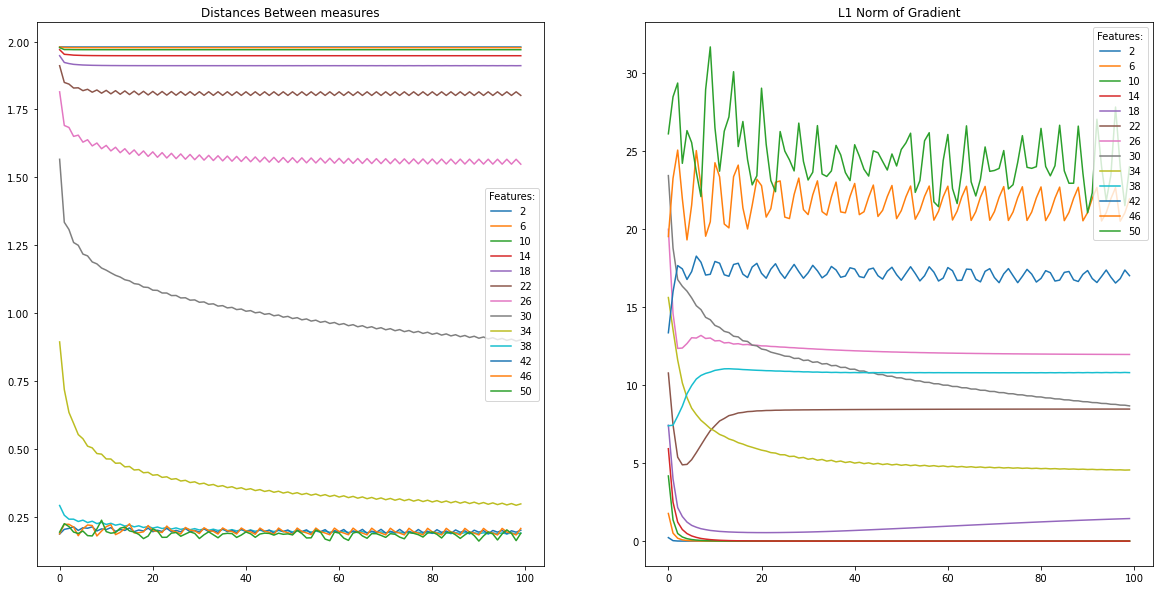

In [9]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
for key, item in history_coefs_all.items():
    ax.plot(item, label=key)
    
ax.set_title("Distances Between measures")
ax.legend(title='Features:')

ax = plt.subplot(122)

for key, item in history_grad_all.items():
    ax.plot(item, label=key)
    
ax.set_title("L1 Norm of Gradient")
ax.legend(title='Features:')

plt.show()

### Singular values experiment

In [10]:
r = 10

sigma = 0.5
A_truth = np.random.normal(size=(X_feature_size, Y_feature_size))
U, s, V = svd(A_truth)

s_flags = np.ones_like(s)
s_flags[r:] = 0

A_small_truth = U@np.diag(s*s_flags)@V

Phi_truth = get_cost(X_truth, Y_truth, A_small_truth)
a_truth, b_truth = Sinkhorn(mu_x, mu_y, Phi_truth, sigma=sigma)
pi_truth = get_distr(a_truth, b_truth, Phi_truth, sigma=sigma)

### Approximation without svd

In [11]:
A_all = {}
history_coefs_all = {}
history_grad_all = {} 
A_approx = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

for i in np.arange(2, 52, step=4):
    X = X_truth[:, :i]
    Y = Y_truth[:, :i]

    mu1 = np.ones(X_batch_size)/X_batch_size
    mu2 = np.ones(Y_batch_size)/Y_batch_size

    A = A_approx[:i, :i]

    A, history_coefs, history_grad = proximal_descent(A, X, mu1, Y, mu2, t=0.5, verbose=False, sigma=sigma, pi_hat=pi_truth)
    A_all[i] = A
    history_coefs_all[i] = history_coefs
    history_grad_all[i] = history_grad

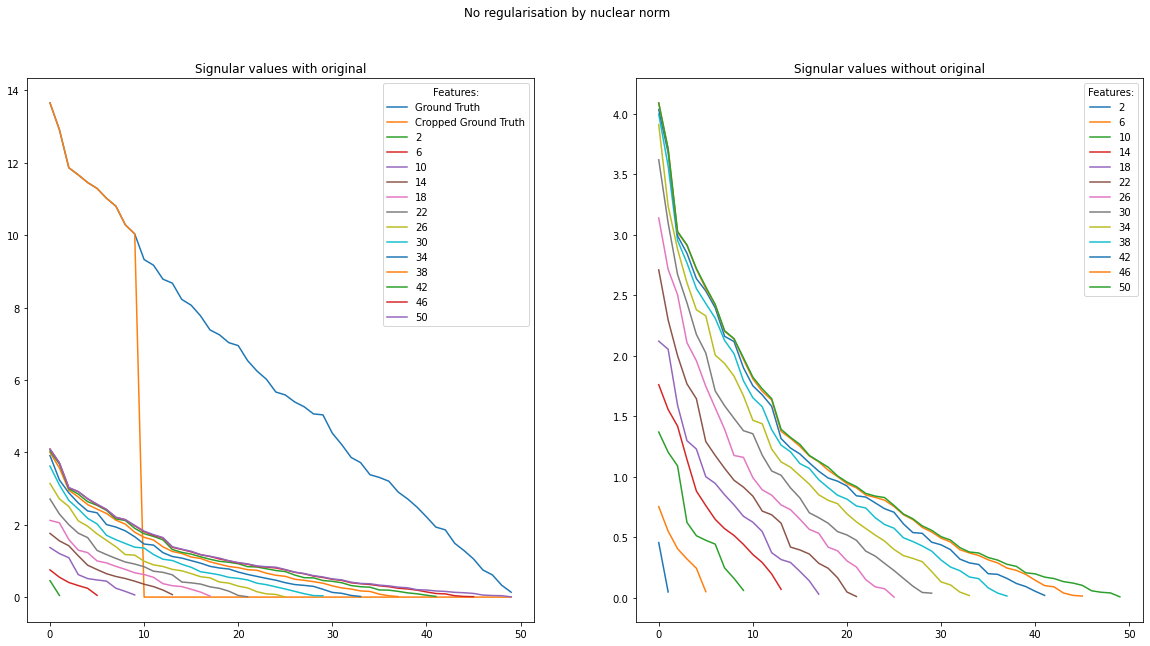

In [12]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

U, s, V = svd(A_truth)
ax1.plot(s, label="Ground Truth")

U, s, V = svd(A_small_truth)
ax1.plot(s, label="Cropped Ground Truth")

for key, item in A_all.items():
    V, s, U  = svd(item)
    ax1.plot(s, label=len(s))
    ax2.plot(s, label=len(s))
ax1.set_title("Signular values with original")
ax1.legend(title='Features:')
ax2.set_title("Signular values without original")
ax2.legend(title='Features:')

plt.suptitle("No regularisation by nuclear norm")
plt.show()

### Approximation with svd

In [13]:
A_all = {}
history_coefs_all = {}
history_grad_all = {} 
A_approx = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

for l in np.arange(0, 1000, step=100)/1000:
    X = X_truth
    Y = Y_truth

    mu1 = np.ones(X_batch_size)/X_batch_size
    mu2 = np.ones(Y_batch_size)/Y_batch_size

    A = A_approx

    A, history_coefs, history_grad = proximal_descent(A, X, mu1, Y, mu2, t=0.5, l=l, verbose=False, svd_flag=True, sigma=sigma, pi_hat=pi_truth)
    A_all[l] = A
    history_coefs_all[l] = history_coefs
    history_grad_all[l] = history_grad

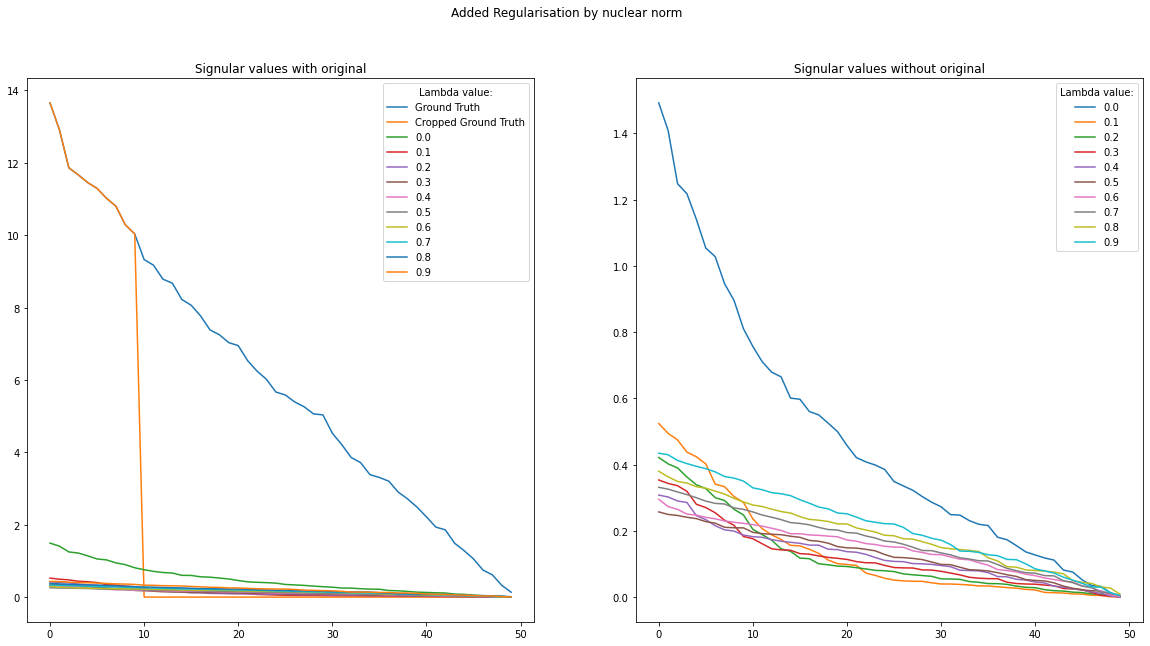

In [14]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

U, s, V = svd(A_truth)
ax1.plot(s, label="Ground Truth")

U, s, V = svd(A_small_truth)
ax1.plot(s, label="Cropped Ground Truth")

for key, item in A_all.items():
    V, s, U  = svd(item)
    ax1.plot(s, label=key)
    ax2.plot(s, label=key)
    
ax1.set_title("Signular values with original")
ax1.legend(title='Lambda value:')
ax2.set_title("Signular values without original")
ax2.legend(title='Lambda value:')

plt.suptitle("Added Regularisation by nuclear norm")
plt.show()

### Ducth Houshold Survay

In [15]:
A_all = {}
history_coefs_all = {}
history_grad_all = {} 

for i in range(1, 24):
    df_num = df_clean.drop(["gez3","teg3"], axis=1)

    Full = df_num.to_numpy(dtype=float)
    mean, std = Full.mean(axis=0), Full.std(axis=0)

    X = (df_num.loc[couple_clean.part1, ].to_numpy(dtype=float) - mean)/std
    Y = (df_num.loc[couple_clean.part2, ].to_numpy(dtype=float) - mean)/std

    X = X[:50, :i]
    Y = Y[:50, :i]
    
    X_population_size, X_feature_size = X.shape
    Y_population_size, Y_feature_size = Y.shape

    mu1 = np.ones(X_population_size)/X_population_size
    mu2 = np.ones(Y_population_size)/Y_population_size

    A = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

    A, history_coefs, history_grad = proximal_descent(A, X, mu1, Y, mu2, verbose=False)
    A_all[i] = A
    history_coefs_all[i] = history_coefs
    history_grad_all[i] = history_grad

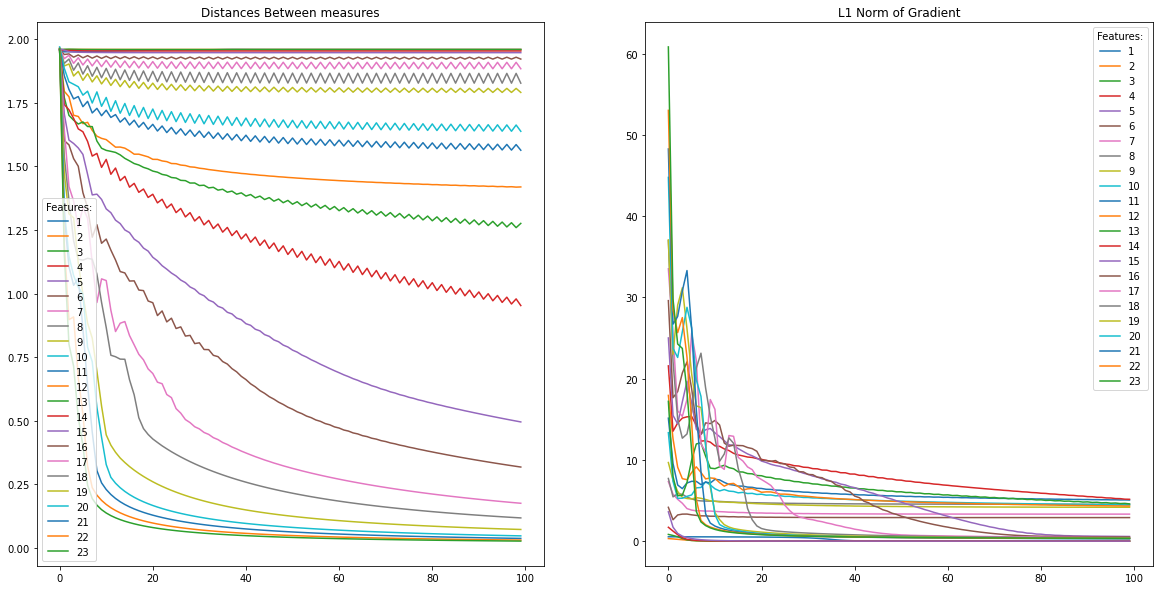

In [16]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
for key, item in history_coefs_all.items():
    ax.plot(item, label=key)
    
ax.set_title("Distances Between measures")
ax.legend(title='Features:')

ax = plt.subplot(122)

for key, item in history_grad_all.items():
    ax.plot(item, label=key)
    
ax.set_title("L1 Norm of Gradient")
ax.legend(title='Features:')

plt.show()

In [17]:
A_all_svd = {}
history_coefs_all_svd = {}
history_grad_all_svd = {} 

for i in range(1, 24):
    df_num = df_clean.drop(["gez3","teg3"], axis=1)

    Full = df_num.to_numpy(dtype=float)
    mean, std = Full.mean(axis=0), Full.std(axis=0)

    X = (df_num.loc[couple_clean.part1, ].to_numpy(dtype=float) - mean)/std
    Y = (df_num.loc[couple_clean.part2, ].to_numpy(dtype=float) - mean)/std

    X = X[:50, :i]
    Y = Y[:50, :i]
    
    X_population_size, X_feature_size = X.shape
    Y_population_size, Y_feature_size = Y.shape

    mu1 = np.ones(X_population_size)/X_population_size
    mu2 = np.ones(Y_population_size)/Y_population_size

    A = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

    A, history_coefs, history_grad = proximal_descent(A, X, mu1, Y, mu2, verbose=False, svd_flag=True)
    A_all_svd[i] = A
    history_coefs_all_svd[i] = history_coefs
    history_grad_all_svd[i] = history_grad

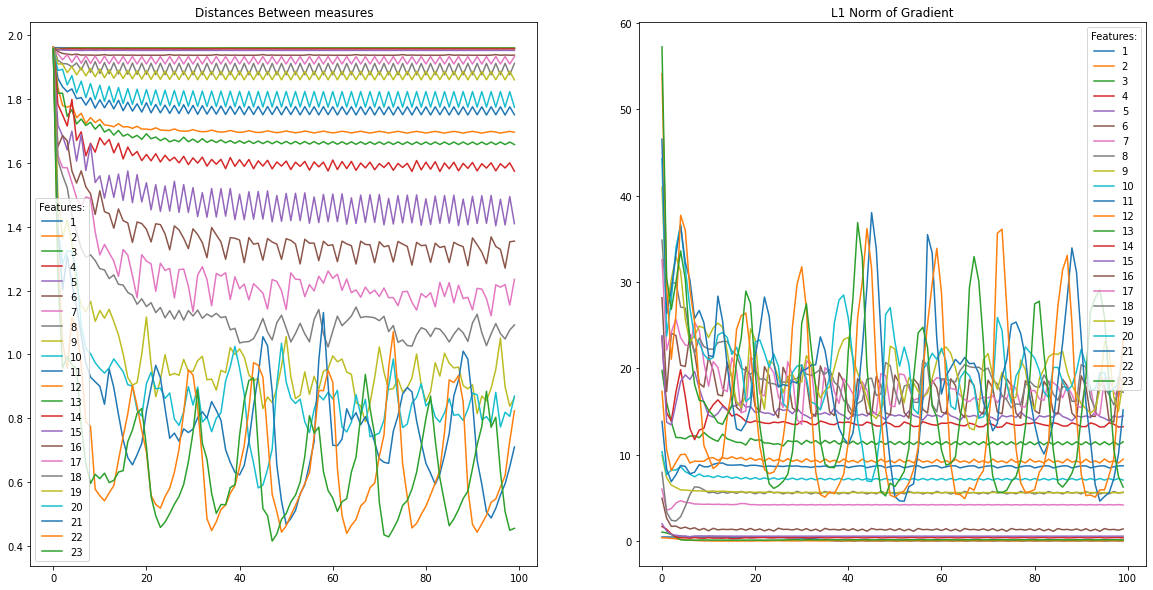

In [18]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
for key, item in history_coefs_all_svd.items():
    ax.plot(item, label=key)
    
ax.set_title("Distances Between measures")

ax.legend(title='Features:')

ax = plt.subplot(122)

for key, item in history_grad_all_svd.items():
    ax.plot(item, label=key)
    
ax.set_title("L1 Norm of Gradient")

ax.legend(title='Features:')
plt.show()

## Lambda influence

In [19]:
A_all_lambda = {}
history_coefs_all_lambda = {}
history_grad_all_lambda = {} 

for l in np.arange(1, 100, step=5)/100:
    df_num = df_clean.drop(["gez3","teg3"], axis=1)

    Full = df_num.to_numpy(dtype=float)
    mean, std = Full.mean(axis=0), Full.std(axis=0)

    X = (df_num.loc[couple_clean.part1, ].to_numpy(dtype=float) - mean)/std
    Y = (df_num.loc[couple_clean.part2, ].to_numpy(dtype=float) - mean)/std

    X = X[:50]
    Y = Y[:50]
    
    X_population_size, X_feature_size = X.shape
    Y_population_size, Y_feature_size = Y.shape

    mu1 = np.ones(X_population_size)/X_population_size
    mu2 = np.ones(Y_population_size)/Y_population_size

    A = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

    A, history_coefs, history_grad = proximal_descent(A, X, mu1, Y, mu2, verbose=False, svd_flag=True, l=l)
    A_all_lambda[l] = A
    history_coefs_all_lambda[l] = history_coefs
    history_grad_all_lambda[l] = history_grad

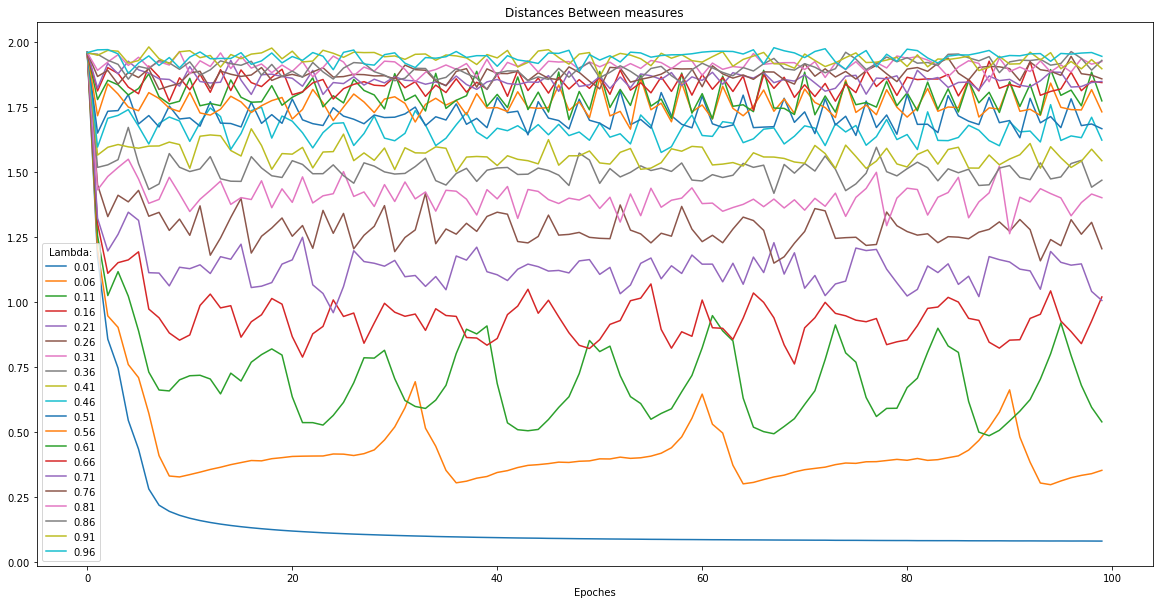

In [20]:
plt.figure(figsize=(20, 10))

for key, item in history_coefs_all_lambda.items():
    plt.plot(item, label=key)
    
plt.title("Distances Between measures")
plt.xlabel("Epoches")
plt.legend(title='Lambda:')
plt.show()

In [21]:
U_o, s_o, V_o = svd(A_all[23])

l2_dist = []
nuclear_norms = []
for key, item in A_all_lambda.items():
    U, s, V = svd(item)
    l2_dist.append(((s_o - s)**2).sum())
    nuclear_norms.append(np.abs(s).sum())

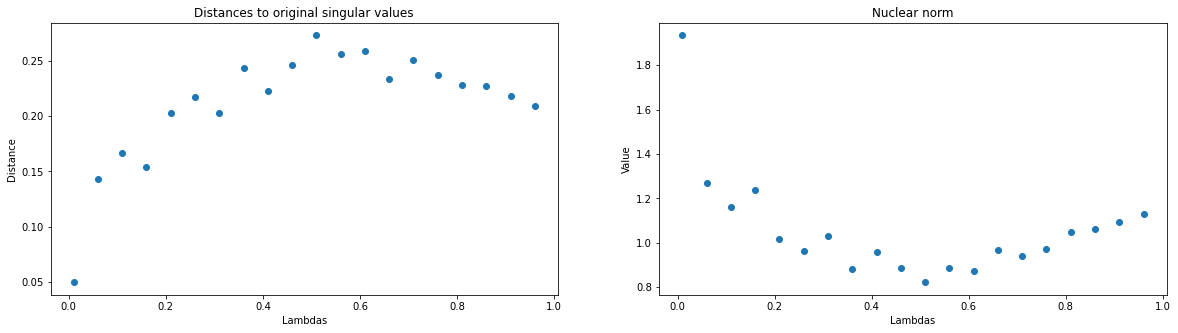

In [22]:
plt.figure(figsize=(20, 5))

ax = plt.subplot(121)
ax.scatter(A_all_lambda.keys(), l2_dist)
ax.set_title("Distances to original singular values")
ax.set_xlabel("Lambdas")
ax.set_ylabel("Distance")

ax = plt.subplot(122)
ax.scatter(A_all_lambda.keys(), nuclear_norms)
ax.set_title("Nuclear norm")
ax.set_xlabel("Lambdas")
ax.set_ylabel("Value")

plt.show()

## Sigma influence

In [23]:
A_all_sigma = {}
history_coefs_all_sigma = {}
history_grad_all_sigma = {} 

for s in np.arange(5, 200, step=10)/100:
    df_num = df_clean.drop(["gez3","teg3"], axis=1)

    Full = df_num.to_numpy(dtype=float)
    mean, std = Full.mean(axis=0), Full.std(axis=0)

    X = (df_num.loc[couple_clean.part1, ].to_numpy(dtype=float) - mean)/std
    Y = (df_num.loc[couple_clean.part2, ].to_numpy(dtype=float) - mean)/std

    X = X[:50]
    Y = Y[:50]
    
    X_population_size, X_feature_size = X.shape
    Y_population_size, Y_feature_size = Y.shape

    mu1 = np.ones(X_population_size)/X_population_size
    mu2 = np.ones(Y_population_size)/Y_population_size

    A = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

    A, history_coefs, history_grad = proximal_descent(A, X, mu1, Y, mu2, verbose=False, svd_flag=False, sigma=s)
    A_all_sigma[s] = A
    history_coefs_all_sigma[s] = history_coefs
    history_grad_all_sigma[s] = history_grad

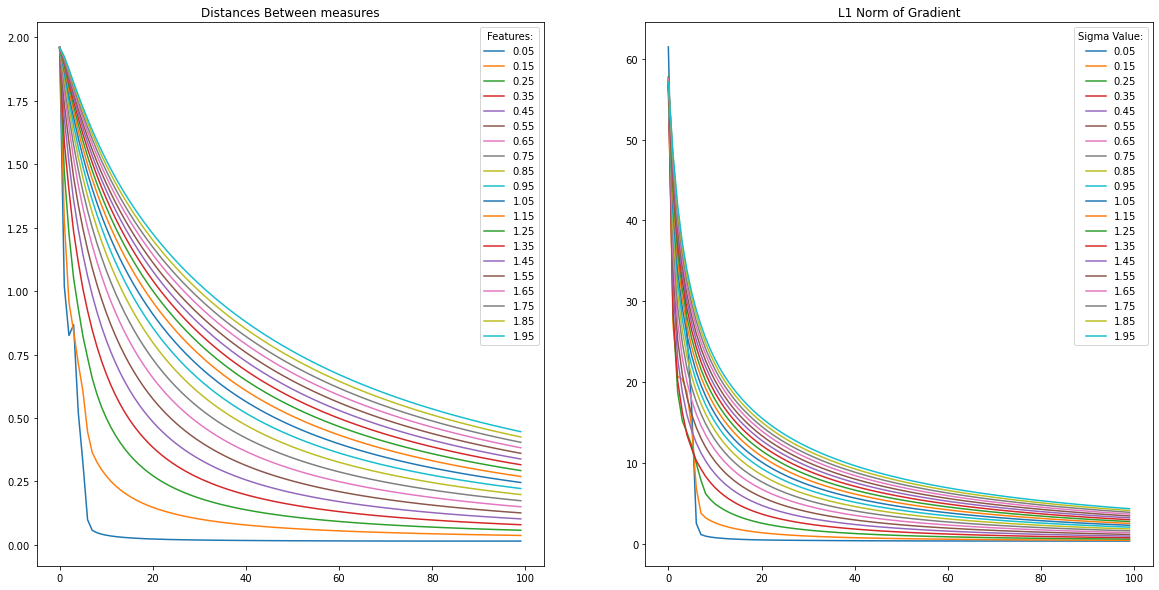

In [24]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
for key, item in history_coefs_all_sigma.items():
    ax.plot(item, label=key)
    
ax.set_title("Distances Between measures")

ax.legend(title='Features:')

ax = plt.subplot(122)

for key, item in history_grad_all_sigma.items():
    ax.plot(item, label=key)
    
ax.set_title("L1 Norm of Gradient")

ax.legend(title='Sigma Value:')
plt.show()

## Gradient step influence

In [25]:
A_all_step = {}
history_coefs_all_step = {}
history_grad_all_step = {} 

for t in np.arange(1, 100, step=10)/1000:
    df_num = df_clean.drop(["gez3","teg3"], axis=1)

    Full = df_num.to_numpy(dtype=float)
    mean, std = Full.mean(axis=0), Full.std(axis=0)

    X = (df_num.loc[couple_clean.part1, ].to_numpy(dtype=float) - mean)/std
    Y = (df_num.loc[couple_clean.part2, ].to_numpy(dtype=float) - mean)/std

    X = X[:50]
    Y = Y[:50]
    
    X_population_size, X_feature_size = X.shape
    Y_population_size, Y_feature_size = Y.shape

    mu1 = np.ones(X_population_size)/X_population_size
    mu2 = np.ones(Y_population_size)/Y_population_size

    A = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

    A, history_coefs, history_grad = proximal_descent(A, X, mu1, Y, mu2, verbose=False, svd_flag=False, t=t)
    A_all_step[t] = A
    history_coefs_all_step[t] = history_coefs
    history_grad_all_step[t] = history_grad

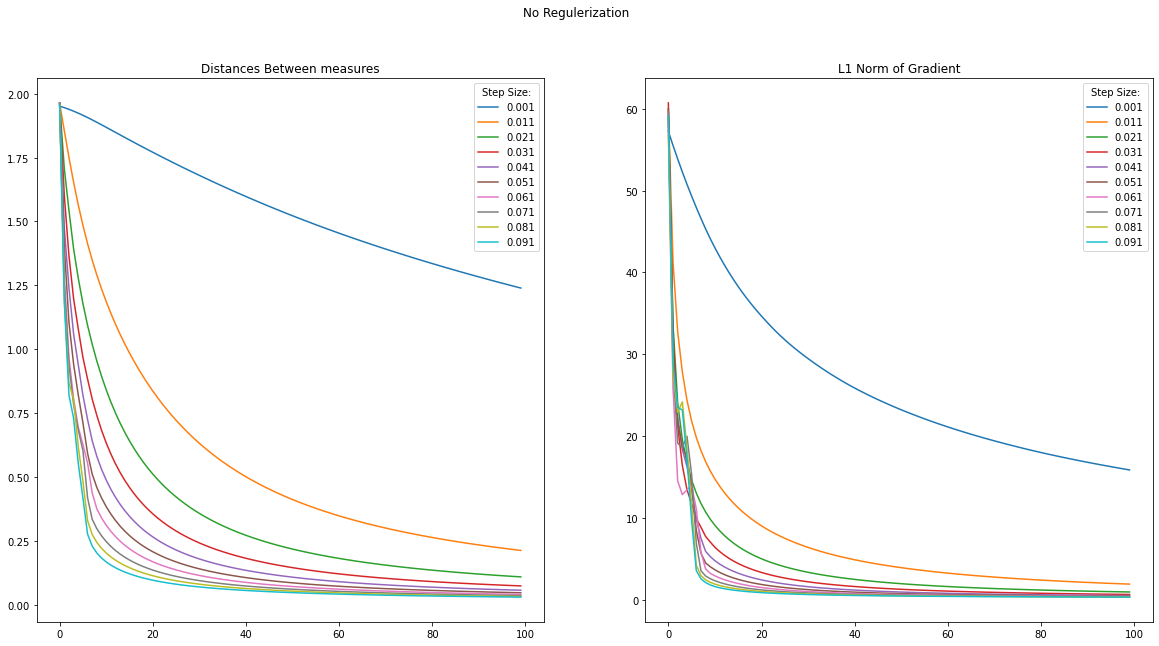

In [26]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
for key, item in history_coefs_all_step.items():
    ax.plot(item, label=key)
    
ax.set_title("Distances Between measures")

ax.legend(title='Step Size:')

ax = plt.subplot(122)

for key, item in history_grad_all_step.items():
    ax.plot(item, label=key)
    
ax.set_title("L1 Norm of Gradient")

ax.legend(title='Step Size:')

plt.suptitle("No Regulerization")
plt.show()

In [27]:
A_all_step = {}
history_coefs_all_step = {}
history_grad_all_step = {} 

for t in np.arange(1, 100, step=10)/1000:
    df_num = df_clean.drop(["gez3","teg3"], axis=1)

    Full = df_num.to_numpy(dtype=float)
    mean, std = Full.mean(axis=0), Full.std(axis=0)

    X = (df_num.loc[couple_clean.part1, ].to_numpy(dtype=float) - mean)/std
    Y = (df_num.loc[couple_clean.part2, ].to_numpy(dtype=float) - mean)/std

    X = X[:50]
    Y = Y[:50]
    
    X_population_size, X_feature_size = X.shape
    Y_population_size, Y_feature_size = Y.shape

    mu1 = np.ones(X_population_size)/X_population_size
    mu2 = np.ones(Y_population_size)/Y_population_size

    A = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

    A, history_coefs, history_grad = proximal_descent(A, X, mu1, Y, mu2, verbose=False, svd_flag=True, t=t)
    A_all_step[t] = A
    history_coefs_all_step[t] = history_coefs
    history_grad_all_step[t] = history_grad

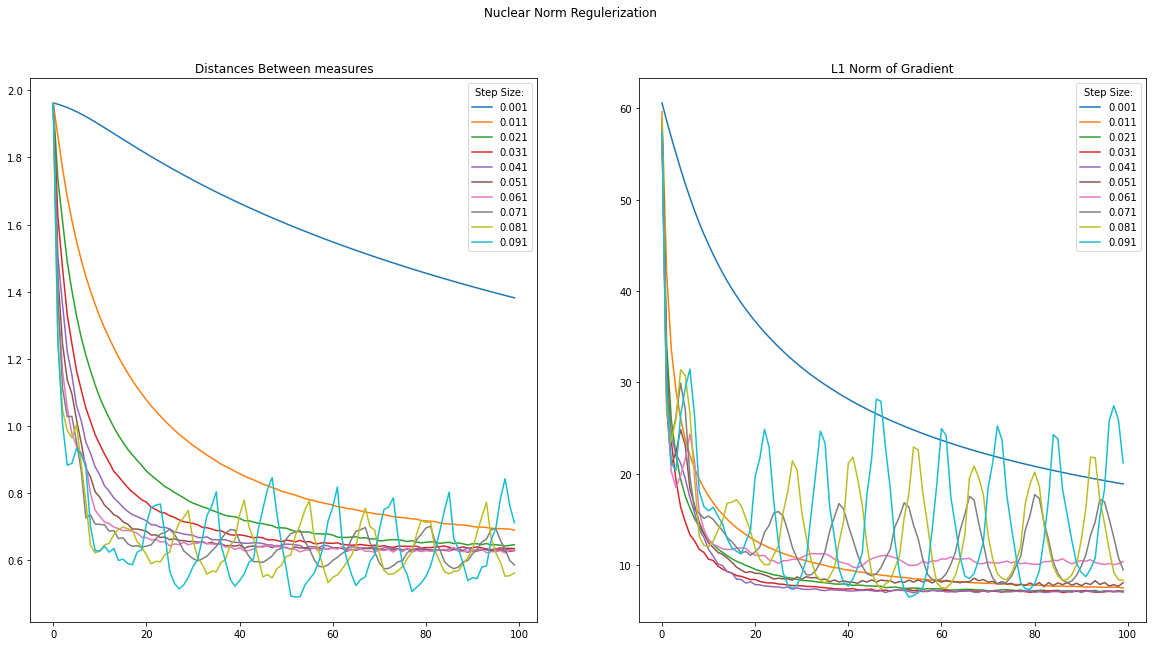

In [28]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
for key, item in history_coefs_all_step.items():
    ax.plot(item, label=key)
    
ax.set_title("Distances Between measures")

ax.legend(title='Step Size:')

ax = plt.subplot(122)

for key, item in history_grad_all_step.items():
    ax.plot(item, label=key)
    
ax.set_title("L1 Norm of Gradient")
ax.legend(title='Step Size:')

plt.suptitle("Nuclear Norm Regulerization")
plt.show()